# Baseline Code for HW1

This is just the baseline code to set up the basic function you need. You need to modify the code yourself to achieve a better result.


## Import packages you need


In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)


In [2]:
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


## Variables

In [3]:
train_path = '../data/HW1.train.csv'    # path to training data
test_path = '../data/HW1.test.csv'      # path to testing data
kFeat = 23                              # Features selection
hdim = 40                               # Hidden layer dimensionality

## Show current device name


In [4]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Basic Function

Do not modify this part


In [5]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'


def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('Truth value')
    plt.ylabel('predicted value')
    plt.title('Truth v.s. Prediction')
    plt.show()


## Data and Preprocess

The function below used to:

1. Read the csv files into python
2. Choose features (you can choose yourself)
3. Split data into training and validation sets.
4. Normalization


In [6]:
# Select K best features
def getKBestFeatures(path: str, k: int):
    dataPre = pd.read_csv(path)
    dataPre = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(dataPre))
    dataPreX = dataPre.iloc[:, 41:94]
    dataPreY = dataPre.iloc[:, -1]
    dataPrefit = SelectKBest(f_regression, k=5).fit(dataPreX, dataPreY)
    featScore = pd.DataFrame(dataPrefit.scores_, index=dataPreX.columns, columns=["Score"])
    feats = list(featScore.nlargest(k, "Score").index - 1)
    # print(f"Feature selected: {feats}")
    return feats


In [7]:
class Dataprocess(Dataset):
    def __init__(self, path, mode='train', modify=False):
        self.mode = mode

        # Read csv file
        with open(path, 'r') as f:
            data = list(csv.reader(f))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if modify == False:
            feats = list(range(93))
        else:
            # Hint:Feature Selection
            # feats = list(range(40, 93))
            feats = getKBestFeatures(train_path, kFeat)
            
        if mode == 'test':
            # Testing set
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training set
            target = data[:, -1]
            data = data[:, feats]

            # Splitting data into training and validation sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features
        # np.savetxt("feat.csv", self.data.data, delimiter=",")
        # self.data = (self.data - self.data.mean(dim=0, keepdim=True)) / self.data.std(dim=0, keepdim=True)
        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'.format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)


## Dataloader

Loads data into batches.


In [8]:
def dataloader(path, mode, batch_size, n_jobs=0, modify=False):
    dataset = Dataprocess(path, mode=mode, modify=modify)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    return dataloader


## Define DNN by pytorch

The DNN consists of 2 fully-connected layers with ReLU activation function


In [9]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Try to modify this DNN to achieve better performance
        self.net = nn.Sequential(
            nn.Linear(input_dim, hdim),
            nn.ReLU(),
            nn.Linear(hdim, 1)
        )

        # Loss function MSE
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # You may try regularization here
        return self.criterion(pred, target)


## Validation


In [10]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss


## Training


In [11]:
def train(tr_set, dv_set, model, config, device):

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                  .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


## Testing


In [12]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds


## Hyper-parameters for DNN


In [13]:
device = get_device()                   # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)    # The trained model will be saved to ./models/
modify = True                           # Need selection

# Tune these hyper-parameters to improve your model
config = {
    'n_epochs': 10000,                  # maximum number of epochs
    'batch_size': 100,                  # mini-batch size for dataloader
    'optimizer': 'SGD',                 # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                   # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 1e-4,                     # learning rate of SGD
        'momentum': 0.5,
        'weight_decay': 1e-3
    },
    'early_stop': 100,                  # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'     # your model will be saved here
}


## Read the dataset


In [14]:
train_set = dataloader(train_path, 'train', config['batch_size'], modify=modify)
validation_set = dataloader(train_path, 'dev', config['batch_size'], modify=modify)
test_set = dataloader(test_path, 'test', config['batch_size'], modify=modify)


Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 23)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 23)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 23)


## Try to train your DNN


In [15]:
print(f"Input dim is {train_set.dataset.dim}")
model = NeuralNet(train_set.dataset.dim).to(device)  # Construct model and move to device


Input dim is 23


In [16]:
model_loss, model_loss_record = train(train_set, validation_set, model, config, device)


Saving model (epoch =    1, loss = 10.7386)
Saving model (epoch =    2, loss = 9.1181)
Saving model (epoch =    3, loss = 7.8627)
Saving model (epoch =    4, loss = 6.9520)
Saving model (epoch =    5, loss = 5.3730)
Saving model (epoch =    6, loss = 4.5413)
Saving model (epoch =    7, loss = 4.1075)
Saving model (epoch =    8, loss = 3.4337)
Saving model (epoch =    9, loss = 3.0145)
Saving model (epoch =   10, loss = 2.6756)
Saving model (epoch =   11, loss = 2.3981)
Saving model (epoch =   13, loss = 2.0722)
Saving model (epoch =   15, loss = 2.0272)
Saving model (epoch =   17, loss = 1.5580)
Saving model (epoch =   24, loss = 1.4202)
Saving model (epoch =   32, loss = 1.4179)
Saving model (epoch =   36, loss = 1.4096)
Saving model (epoch =   39, loss = 1.2713)
Saving model (epoch =   43, loss = 1.2628)
Saving model (epoch =   46, loss = 1.2586)
Saving model (epoch =   49, loss = 1.2403)
Saving model (epoch =   53, loss = 1.2366)
Saving model (epoch =   58, loss = 1.2236)
Saving mod

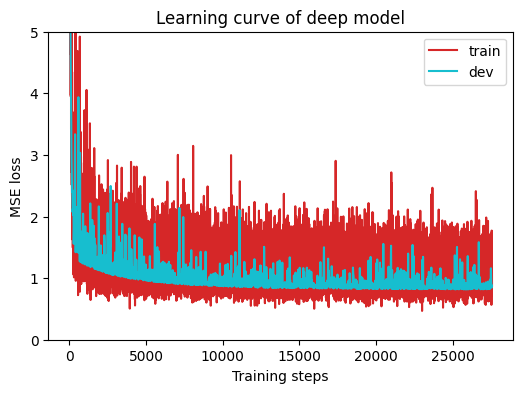

In [17]:
plot_learning_curve(model_loss_record, title='deep model')


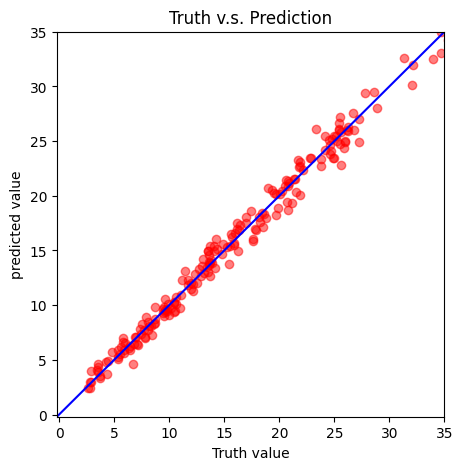

In [18]:
del model
model = NeuralNet(train_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(validation_set, model, device)  # Show prediction on the validation set


## Testing

Get the prediction result and save it to csv file named 'prediction.csv'


In [19]:
def save_pred(preds, file):
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])


preds = test(test_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'prediction.csv')         # save prediction file to pred.csv


Saving results to prediction.csv


## Hints for better result

-   Feature selection
-   DNN architecture
-   Training (mini-batch/optimizer/learning rate)
-   Regularization
